### Importação das bibliotecas que utilizaremos para trabalhar os dados e o arquivo chest_xray que contém as imagens para treinamento e teste

In [184]:

import pandas as pd 
import cv2            
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
#from keras.utils.np_utils import to_categorical
import tensorflow as tf
print(os.listdir("/home/vinicius/Documentos/UTFPR/IA/projeto_ia/Inceptionv3_Pneumonia/chest_xray/chest_xray"))

['.DS_Store', 'test', 'train']


### Imprimindo os arquivos que contém chest_xray/train, esse arquivo possui as imagens de treinamento

In [185]:
print(os.listdir("/home/vinicius/Documentos/UTFPR/IA/projeto_ia/Inceptionv3_Pneumonia/chest_xray/chest_xray/train"))


['.DS_Store', 'NORMAL', 'PNEUMONIA']


### Selecionando as imagens dos diretórios de treinamento e teste, e separando as na proporção de 80% treinamento e 20% teste.

In [186]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/home/vinicius/Documentos/UTFPR/IA/projeto_ia/Inceptionv3_Pneumonia/chest_xray/chest_xray/train"
TEST_DIR = "/home/vinicius/Documentos/UTFPR/IA/projeto_ia/Inceptionv3_Pneumonia/chest_xray/chest_xray/test"

filenames = tf.io.gfile.glob(str(TRAIN_DIR))
filenames.extend(tf.io.gfile.glob(str(TEST_DIR)))

train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
print(type(test_filenames))

<class 'list'>


### Função que buscar o rótulo(Normal ou PNEUMONIA) de cada imagem

In [187]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + '/' + nextDir
            #tqdm mostra o progresso
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    #print(X)
                    y.append(label)
                    #print(y)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

### Imprime a dimensão do DataFrame

In [188]:
#retorna as imagens de train em array
train_filenames = "".join(map(str,train_filenames ))
X_train, y_train = get_data(train_filenames)
#print(train_filenames)


100%|██████████| 208/208 [00:25<00:00,  8.19it/s]


In [189]:
#retorna as imagens de teste em array
test_filenames = "".join(map(str,test_filenames ))
X_test , y_test = get_data(test_filenames)

100%|██████████| 652/652 [01:30<00:00,  7.22it/s]


In [190]:
print(X_train.shape,'\n',X_test.shape)
#X_train

(344, 150, 150, 3) 
 (1390, 150, 150, 3)


In [191]:
print(y_train.shape,'\n',y_test.shape)

(344,) 
 (1390,)


### Converte uma classe vetor em matrix de classe binaria

In [192]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [193]:
#Cria uma lista com o nome das imagens
#listdir tras o nome de todos objetos contidos no diretorio
Pimages = os.listdir(TRAIN_DIR + '/' + "PNEUMONIA")
#print(Pimages)
Nimages = os.listdir(TRAIN_DIR + '/' + "NORMAL")

### Plotando as imagens de Raio X de Não Pneumonia e Pneumonia dos pacientes

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


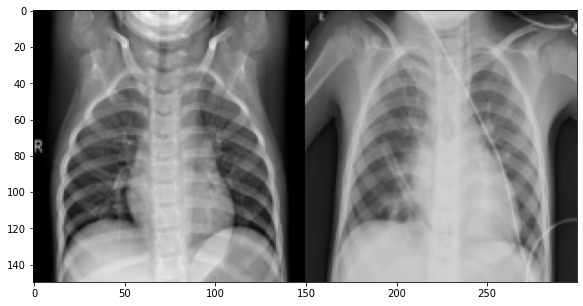

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


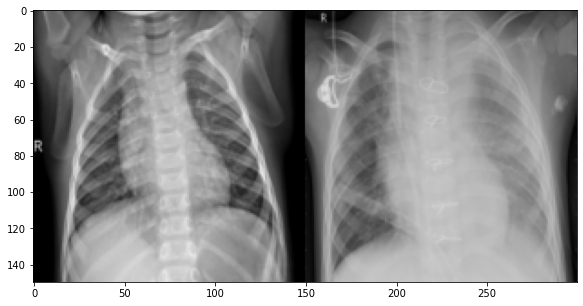

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


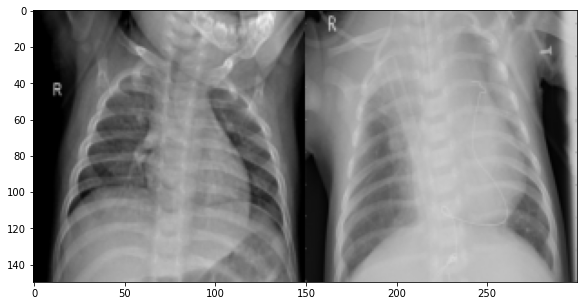

In [195]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR + '/PNEUMONIA/' + Pimages[i])
    #print(imagep1)
    imagep1 = skimage.transform.resize(imagep1, (150,150,3), mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR + '/NORMAL/' + Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150,150,3), mode = 'reflect')
    pair = np.concatenate((imagen1, imagep1), axis = 1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(12,15):
    plotter(i)

### Reduz a taxa de aprendizagem quando uma métrica para de melhorar, input da taxa de aprendizagem

In [196]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.001, epsilon=0.0001, patience=1, verbose=1)

### Chamada para salvar o modelo Keras ou pesos do modelo com alguma frequência no arquivo transferlearning_weights.hdf5

In [198]:
filepath="transferlearning_weights.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Importando biblioteca keras

In [199]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

### Padronizando a dimensão do Dataframe

In [200]:
X_train=X_train.reshape(344,150,150,3)
X_test=X_test.reshape(1390,150,150,3)

In [201]:
print(np.shape(X_train))

(344, 150, 150, 3)


### Importando InceptionV3 de Keras, com os pesos do imagenet (pré-treinamento)

In [203]:

from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False )


### Configurando o modelo e as camadas conforme proposta 

In [204]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import backend as K

x = base_model.output

x = Dropout(0.5)(x)

x = GlobalMaxPooling2D()(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(2, activation='sigmoid')(x)

### O modelo agrupa camadas em um objeto com recursos de treinamento e inferência.

In [205]:
from keras.models import Model
model= Model(base_model.input,predictions)

### Configura o modelo de treinamento

In [206]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

### Imprime um resumo da string da rede

In [207]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

activation_364 (Activation)     (None, None, None, 3 0           batch_normalization_364[0][0]    
__________________________________________________________________________________________________
activation_365 (Activation)     (None, None, None, 3 0           batch_normalization_365[0][0]    
__________________________________________________________________________________________________
batch_normalization_366 (BatchN (None, None, None, 1 576         conv2d_366[0][0]                 
__________________________________________________________________________________________________
activation_358 (Activation)     (None, None, None, 3 0           batch_normalization_358[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_360[0][0]             
                                                                 activation_361[0][0]             
__________

### Imput de alguns parâmetros conforme proposta

In [208]:
batch_size = 32
epochs = 500
Dropout = 0.5


### Treina o modelo

In [209]:
history = model.fit(x= X_train, y = y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,epochs = epochs,batch_size = batch_size)

Epoch 1/500
11/11 [==============================] - 55s 5s/step - loss: 1.0579 - accuracy: 0.7511 - val_loss: 95.1021 - val_accuracy: 0.4683
Epoch 2/500
11/11 [==============================] - 48s 5s/step - loss: 0.0936 - accuracy: 0.9720 - val_loss: 255.7841 - val_accuracy: 0.4683
Epoch 3/500
11/11 [==============================] - 48s 5s/step - loss: 0.2032 - accuracy: 0.9050 - val_loss: 156.4262 - val_accuracy: 0.4683
Epoch 4/500
11/11 [==============================] - 48s 5s/step - loss: 0.1036 - accuracy: 0.9647 - val_loss: 76.5948 - val_accuracy: 0.4871
Epoch 5/500
11/11 [==============================] - 48s 5s/step - loss: 0.0450 - accuracy: 0.9895 - val_loss: 7.9695 - val_accuracy: 0.8216
Epoch 6/500
11/11 [==============================] - 48s 5s/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 2.9867 - val_accuracy: 0.7856
Epoch 7/500
11/11 [==============================] - 48s 5s/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 5.8515 - val_accuracy: 0.7460
Epoch 8

Epoch 23/500
11/11 [==============================] - 48s 5s/step - loss: 0.0118 - accuracy: 0.9985 - val_loss: 0.5892 - val_accuracy: 0.8655
Epoch 24/500
11/11 [==============================] - 48s 5s/step - loss: 0.0068 - accuracy: 0.9958 - val_loss: 0.5469 - val_accuracy: 0.8784
Epoch 25/500
11/11 [==============================] - 48s 5s/step - loss: 1.3976e-04 - accuracy: 1.0000 - val_loss: 0.5739 - val_accuracy: 0.8504
Epoch 26/500
11/11 [==============================] - 48s 5s/step - loss: 8.6601e-04 - accuracy: 1.0000 - val_loss: 0.4831 - val_accuracy: 0.8871
Epoch 27/500
11/11 [==============================] - 48s 5s/step - loss: 1.4136e-04 - accuracy: 1.0000 - val_loss: 0.4544 - val_accuracy: 0.8993
Epoch 28/500
11/11 [==============================] - 48s 5s/step - loss: 4.0755e-04 - accuracy: 1.0000 - val_loss: 0.4576 - val_accuracy: 0.9014
Epoch 29/500
11/11 [==============================] - 48s 5s/step - loss: 4.8093e-05 - accuracy: 1.0000 - val_loss: 0.4766 - val_acc

Epoch 44/500
11/11 [==============================] - 48s 5s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.8856
Epoch 45/500
11/11 [==============================] - 48s 5s/step - loss: 0.0039 - accuracy: 0.9982 - val_loss: 0.3686 - val_accuracy: 0.9029
Epoch 46/500
11/11 [==============================] - 48s 5s/step - loss: 0.0541 - accuracy: 0.9811 - val_loss: 1.1499 - val_accuracy: 0.5784
Epoch 47/500
11/11 [==============================] - 48s 5s/step - loss: 0.0472 - accuracy: 0.9846 - val_loss: 2.1071 - val_accuracy: 0.2964
Epoch 48/500
11/11 [==============================] - 48s 5s/step - loss: 0.0237 - accuracy: 0.9909 - val_loss: 1.0304 - val_accuracy: 0.4892
Epoch 49/500
11/11 [==============================] - 48s 5s/step - loss: 0.0812 - accuracy: 0.9764 - val_loss: 18.7511 - val_accuracy: 0.6165
Epoch 50/500
11/11 [==============================] - 48s 5s/step - loss: 0.2097 - accuracy: 0.9403 - val_loss: 1453309.0000 - val_accuracy: 0.4683

11/11 [==============================] - 48s 5s/step - loss: 0.0032 - accuracy: 0.9983 - val_loss: 1.6535 - val_accuracy: 0.5734
Epoch 66/500
11/11 [==============================] - 48s 5s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.6252 - val_accuracy: 0.6216
Epoch 67/500
11/11 [==============================] - 48s 5s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4257 - val_accuracy: 0.8683
Epoch 68/500
11/11 [==============================] - 48s 5s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.6152 - val_accuracy: 0.7360
Epoch 69/500
11/11 [==============================] - 48s 5s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.3153 - val_accuracy: 0.7281
Epoch 70/500
11/11 [==============================] - 48s 5s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.2965 - val_accuracy: 0.7727
Epoch 71/500
11/11 [==============================] - 48s 5s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6464 - val_accuracy: 0.8504
Epoch 72/500
11/11 

11/11 [==============================] - 48s 5s/step - loss: 2.3158e-04 - accuracy: 1.0000 - val_loss: 0.3873 - val_accuracy: 0.9245
Epoch 108/500
11/11 [==============================] - 48s 5s/step - loss: 2.1059e-04 - accuracy: 1.0000 - val_loss: 0.3842 - val_accuracy: 0.9245
Epoch 109/500
11/11 [==============================] - 48s 5s/step - loss: 8.0076e-05 - accuracy: 1.0000 - val_loss: 0.3831 - val_accuracy: 0.9237
Epoch 110/500
11/11 [==============================] - 48s 5s/step - loss: 7.9297e-05 - accuracy: 1.0000 - val_loss: 0.3822 - val_accuracy: 0.9237
Epoch 111/500
11/11 [==============================] - 48s 5s/step - loss: 6.7692e-05 - accuracy: 1.0000 - val_loss: 0.3829 - val_accuracy: 0.9237
Epoch 112/500
11/11 [==============================] - 48s 5s/step - loss: 3.1489e-04 - accuracy: 1.0000 - val_loss: 0.3853 - val_accuracy: 0.9194
Epoch 113/500
11/11 [==============================] - 48s 5s/step - loss: 5.2731e-05 - accuracy: 1.0000 - val_loss: 0.3879 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 1.2131e-05 - accuracy: 1.0000 - val_loss: 0.4157 - val_accuracy: 0.9194
Epoch 150/500
11/11 [==============================] - 48s 5s/step - loss: 1.9721e-05 - accuracy: 1.0000 - val_loss: 0.4164 - val_accuracy: 0.9194
Epoch 151/500
11/11 [==============================] - 48s 5s/step - loss: 1.2438e-05 - accuracy: 1.0000 - val_loss: 0.4163 - val_accuracy: 0.9194
Epoch 152/500
11/11 [==============================] - 48s 5s/step - loss: 1.4253e-05 - accuracy: 1.0000 - val_loss: 0.4171 - val_accuracy: 0.9194
Epoch 153/500
11/11 [==============================] - 48s 5s/step - loss: 4.1817e-05 - accuracy: 1.0000 - val_loss: 0.4179 - val_accuracy: 0.9194
Epoch 154/500
11/11 [==============================] - 48s 5s/step - loss: 1.3415e-05 - accuracy: 1.0000 - val_loss: 0.4181 - val_accuracy: 0.9194
Epoch 155/500
11/11 [==============================] - 48s 5s/step - loss: 1.3565e-05 - accuracy: 1.0000 - val_loss: 0.4185 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 8.6845e-06 - accuracy: 1.0000 - val_loss: 0.4369 - val_accuracy: 0.9209
Epoch 192/500
11/11 [==============================] - 48s 5s/step - loss: 3.0763e-06 - accuracy: 1.0000 - val_loss: 0.4381 - val_accuracy: 0.9209
Epoch 193/500
11/11 [==============================] - 48s 5s/step - loss: 6.0406e-06 - accuracy: 1.0000 - val_loss: 0.4387 - val_accuracy: 0.9209
Epoch 194/500
11/11 [==============================] - 48s 5s/step - loss: 9.7813e-06 - accuracy: 1.0000 - val_loss: 0.4381 - val_accuracy: 0.9209
Epoch 195/500
11/11 [==============================] - 48s 5s/step - loss: 7.9241e-06 - accuracy: 1.0000 - val_loss: 0.4392 - val_accuracy: 0.9209
Epoch 196/500
11/11 [==============================] - 48s 5s/step - loss: 4.4542e-06 - accuracy: 1.0000 - val_loss: 0.4400 - val_accuracy: 0.9209
Epoch 197/500
11/11 [==============================] - 48s 5s/step - loss: 1.0395e-05 - accuracy: 1.0000 - val_loss: 0.4399 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 7.3573e-06 - accuracy: 1.0000 - val_loss: 0.4727 - val_accuracy: 0.9144
Epoch 234/500
11/11 [==============================] - 48s 5s/step - loss: 7.6400e-06 - accuracy: 1.0000 - val_loss: 0.4730 - val_accuracy: 0.9137
Epoch 235/500
11/11 [==============================] - 48s 5s/step - loss: 3.3215e-06 - accuracy: 1.0000 - val_loss: 0.4753 - val_accuracy: 0.9137
Epoch 236/500
11/11 [==============================] - 48s 5s/step - loss: 4.6201e-06 - accuracy: 1.0000 - val_loss: 0.4788 - val_accuracy: 0.9144
Epoch 237/500
11/11 [==============================] - 48s 5s/step - loss: 2.1240e-06 - accuracy: 1.0000 - val_loss: 0.4820 - val_accuracy: 0.9137
Epoch 238/500
11/11 [==============================] - 48s 5s/step - loss: 1.4733e-05 - accuracy: 1.0000 - val_loss: 0.4847 - val_accuracy: 0.9137
Epoch 239/500
11/11 [==============================] - 48s 5s/step - loss: 1.0733e-05 - accuracy: 1.0000 - val_loss: 0.4855 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 1.2081e-06 - accuracy: 1.0000 - val_loss: 0.5076 - val_accuracy: 0.9151
Epoch 276/500
11/11 [==============================] - 48s 5s/step - loss: 1.2208e-06 - accuracy: 1.0000 - val_loss: 0.5086 - val_accuracy: 0.9158
Epoch 277/500
11/11 [==============================] - 48s 5s/step - loss: 3.0803e-06 - accuracy: 1.0000 - val_loss: 0.5099 - val_accuracy: 0.9158
Epoch 278/500
11/11 [==============================] - 48s 5s/step - loss: 1.0357e-05 - accuracy: 1.0000 - val_loss: 0.5093 - val_accuracy: 0.9158
Epoch 279/500
11/11 [==============================] - 48s 5s/step - loss: 2.3707e-06 - accuracy: 1.0000 - val_loss: 0.5106 - val_accuracy: 0.9158
Epoch 280/500
11/11 [==============================] - 48s 5s/step - loss: 1.1918e-06 - accuracy: 1.0000 - val_loss: 0.5104 - val_accuracy: 0.9158
Epoch 281/500
11/11 [==============================] - 48s 5s/step - loss: 4.9529e-06 - accuracy: 1.0000 - val_loss: 0.5106 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 5.5973e-07 - accuracy: 1.0000 - val_loss: 0.5152 - val_accuracy: 0.9144
Epoch 318/500
11/11 [==============================] - 48s 5s/step - loss: 4.4283e-06 - accuracy: 1.0000 - val_loss: 0.5141 - val_accuracy: 0.9144
Epoch 319/500
11/11 [==============================] - 48s 5s/step - loss: 1.4557e-06 - accuracy: 1.0000 - val_loss: 0.5149 - val_accuracy: 0.9144
Epoch 320/500
11/11 [==============================] - 48s 5s/step - loss: 1.0543e-06 - accuracy: 1.0000 - val_loss: 0.5142 - val_accuracy: 0.9158
Epoch 321/500
11/11 [==============================] - 48s 5s/step - loss: 4.0186e-06 - accuracy: 1.0000 - val_loss: 0.5147 - val_accuracy: 0.9144
Epoch 322/500
11/11 [==============================] - 48s 5s/step - loss: 2.0849e-06 - accuracy: 1.0000 - val_loss: 0.5149 - val_accuracy: 0.9144
Epoch 323/500
11/11 [==============================] - 48s 5s/step - loss: 7.9842e-06 - accuracy: 1.0000 - val_loss: 0.5151 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 4.3840e-07 - accuracy: 1.0000 - val_loss: 0.5253 - val_accuracy: 0.9151
Epoch 360/500
11/11 [==============================] - 48s 5s/step - loss: 7.3805e-07 - accuracy: 1.0000 - val_loss: 0.5257 - val_accuracy: 0.9158
Epoch 361/500
11/11 [==============================] - 48s 5s/step - loss: 8.3671e-07 - accuracy: 1.0000 - val_loss: 0.5243 - val_accuracy: 0.9151
Epoch 362/500
11/11 [==============================] - 48s 5s/step - loss: 7.6132e-06 - accuracy: 1.0000 - val_loss: 0.5232 - val_accuracy: 0.9151
Epoch 363/500
11/11 [==============================] - 48s 5s/step - loss: 5.3917e-05 - accuracy: 1.0000 - val_loss: 0.5207 - val_accuracy: 0.9137
Epoch 364/500
11/11 [==============================] - 48s 5s/step - loss: 7.3221e-07 - accuracy: 1.0000 - val_loss: 0.5209 - val_accuracy: 0.9144
Epoch 365/500
11/11 [==============================] - 48s 5s/step - loss: 4.9085e-07 - accuracy: 1.0000 - val_loss: 0.5205 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 1.5220e-06 - accuracy: 1.0000 - val_loss: 0.5272 - val_accuracy: 0.9187
Epoch 402/500
11/11 [==============================] - 48s 5s/step - loss: 8.4245e-07 - accuracy: 1.0000 - val_loss: 0.5264 - val_accuracy: 0.9194
Epoch 403/500
11/11 [==============================] - 48s 5s/step - loss: 8.7538e-07 - accuracy: 1.0000 - val_loss: 0.5267 - val_accuracy: 0.9194
Epoch 404/500
11/11 [==============================] - 48s 5s/step - loss: 6.6123e-07 - accuracy: 1.0000 - val_loss: 0.5265 - val_accuracy: 0.9201
Epoch 405/500
11/11 [==============================] - 48s 5s/step - loss: 4.3822e-07 - accuracy: 1.0000 - val_loss: 0.5277 - val_accuracy: 0.9201
Epoch 406/500
11/11 [==============================] - 48s 5s/step - loss: 2.6120e-07 - accuracy: 1.0000 - val_loss: 0.5287 - val_accuracy: 0.9194
Epoch 407/500
11/11 [==============================] - 48s 5s/step - loss: 7.0783e-07 - accuracy: 1.0000 - val_loss: 0.5289 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 9.4200e-07 - accuracy: 1.0000 - val_loss: 0.5337 - val_accuracy: 0.9194
Epoch 444/500
11/11 [==============================] - 48s 5s/step - loss: 7.3603e-07 - accuracy: 1.0000 - val_loss: 0.5331 - val_accuracy: 0.9194
Epoch 445/500
11/11 [==============================] - 48s 5s/step - loss: 9.0304e-07 - accuracy: 1.0000 - val_loss: 0.5335 - val_accuracy: 0.9201
Epoch 446/500
11/11 [==============================] - 48s 5s/step - loss: 2.9186e-07 - accuracy: 1.0000 - val_loss: 0.5351 - val_accuracy: 0.9201
Epoch 447/500
11/11 [==============================] - 48s 5s/step - loss: 9.2830e-07 - accuracy: 1.0000 - val_loss: 0.5352 - val_accuracy: 0.9201
Epoch 448/500
11/11 [==============================] - 48s 5s/step - loss: 5.6013e-06 - accuracy: 1.0000 - val_loss: 0.5354 - val_accuracy: 0.9201
Epoch 449/500
11/11 [==============================] - 48s 5s/step - loss: 4.7193e-07 - accuracy: 1.0000 - val_loss: 0.5350 - val_ac

11/11 [==============================] - 48s 5s/step - loss: 7.6379e-07 - accuracy: 1.0000 - val_loss: 0.5415 - val_accuracy: 0.9209
Epoch 486/500
11/11 [==============================] - 48s 5s/step - loss: 4.2478e-07 - accuracy: 1.0000 - val_loss: 0.5427 - val_accuracy: 0.9209
Epoch 487/500
11/11 [==============================] - 48s 5s/step - loss: 2.9307e-07 - accuracy: 1.0000 - val_loss: 0.5435 - val_accuracy: 0.9209
Epoch 488/500
11/11 [==============================] - 48s 5s/step - loss: 1.3381e-07 - accuracy: 1.0000 - val_loss: 0.5447 - val_accuracy: 0.9201
Epoch 489/500
11/11 [==============================] - 48s 5s/step - loss: 1.9315e-06 - accuracy: 1.0000 - val_loss: 0.5444 - val_accuracy: 0.9209
Epoch 490/500
11/11 [==============================] - 48s 5s/step - loss: 2.2928e-07 - accuracy: 1.0000 - val_loss: 0.5456 - val_accuracy: 0.9201
Epoch 491/500
11/11 [==============================] - 48s 5s/step - loss: 4.5991e-07 - accuracy: 1.0000 - val_loss: 0.5455 - val_ac

### Histórico dos resultados para accuracy e loss. Conforme analisamos o modelo teve um ótimo resultado para treinamento e teste. No inicio oscilou até encontrar o minímo global através do gradiente

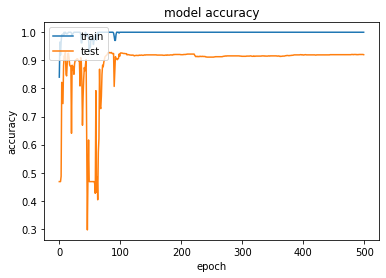

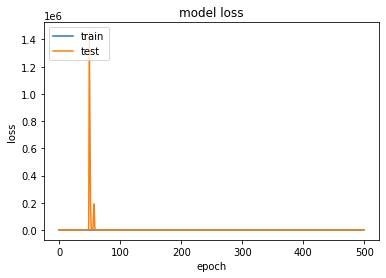

In [210]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Fazendo a predição de X_test com keras

In [211]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [212]:
print(y_true)

[0 0 0 ... 1 1 1]


### Apresentando a matriz de confusão, entre os resultados esperados com a predição

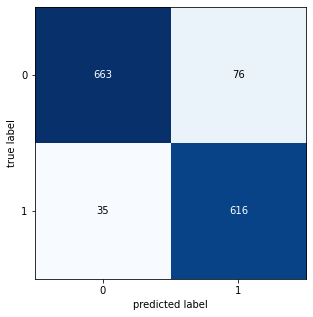

In [213]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### Imprimindo os valores da precisão, revocação, f1-score e acuracia

In [214]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, pred))
print(classification_report(y_true, pred))

[[663  76]
 [ 35 616]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       739
           1       0.89      0.95      0.92       651

    accuracy                           0.92      1390
   macro avg       0.92      0.92      0.92      1390
weighted avg       0.92      0.92      0.92      1390

